### ANN for classification, example 1, mobile phone price class classification

**This is experimentation with Keras Tuner, see details below**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


# THIS IS OPTIONAL, so you can comment out the following code
# if you don't wish to remove randomness
# you might want to lock down the random seed throughout,
# so you we get same results every time (given we change nothing in the data afterwards)

# random seed locking code original from ChatGPT => has been tested that it works
import random
import os

# Set a fixed seed value
SEED = 12345

# 1. Set Python's built-in random module seed
random.seed(SEED)

# 2. Set NumPy random seed
np.random.seed(SEED)

# 3. Set TensorFlow seed
tf.random.set_seed(SEED)

# 4. Set environment variables (affects some backend randomness)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Optional: control inter-op and intra-op parallelism for determinism
# (can slightly slow down training, but improves reproducibility)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
# load the data
df = pd.read_csv("mobilepricerangeclass.csv")

In [3]:
# see the column explanations here
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
# even distribution along the target classes
df['price_range'].value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

In [5]:
# let' remove some of the variables that are probably not extremely important in this dataset
# NOTE! we didn't spend much time analyzing/optimizing these, this just an example
# on how you can use correlation matrix, SelectKBest etc. to choose your variables
removables = ['touch_screen', 'dual_sim', 'clock_speed', 'm_dep', 'three_g', 'four_g', 'wifi', 'blue']
df = df.drop(removables, axis=1)

In [6]:
# let's assign actual names for the price classes
# so we have nicer metrics and results later (after training model)
df['price_range'] = df['price_range'].replace({
    0: "1: Cheap",
    1: "2: Avg-",
    2: "3: Avg+",
    3: "4: Expensive"
})

In [7]:
# everything else except the target variable
X = df.drop("price_range", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['price_range']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

# save the categories into a helper list for later purposes
categories = list(le.classes_)
categories

['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']

### train/test/validation -split

In [8]:
# this time, let's split the data into 65% (training data) and 35% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35)

# step 2, split the temporary data in HALF (0.5) => 17.5% test and 17.5% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### USE KERAS TUNER TO FIND OPTIMAL PARAMETERS

In [9]:
# pip install keras-tuner
import keras_tuner

def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=4, max_value=96, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(hp.Float("l1", min_value=0.025, max_value=0.35, sampling="log"))
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            hp.Float("rate", min_value=0.1, max_value=0.5, step=0.025)
            ))

    # try additional layers, 1-3 extra layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=8, max_value=96, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(len(categories), activation="softmax"))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy', metrics=['accuracy']
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="optimizations1",
    project_name="classification1test",
)

# start searching
tuner.search(X_train, y_train, epochs=250, validation_data=(X_val, y_val))

Trial 5 Complete [00h 01m 29s]
val_accuracy: 0.9428571462631226

Best val_accuracy So Far: 0.9442857205867767
Total elapsed time: 00h 05m 38s


In [10]:
fsdaafdsafsd

NameError: name 'fsdaafdsafsd' is not defined

In [11]:
# print out the result and suggestions
tuner.results_summary()

Results summary
Results in optimizations1\classification1test
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
units_0: 64
activation: relu
l1: 0.14404386359839785
dropout: True
num_layers: 2
units_1: 92
lr: 0.0005495772755430749
rate: 0.1
units_2: 8
Score: 0.9442857205867767

Trial 4 summary
Hyperparameters:
units_0: 84
activation: relu
l1: 0.09277436194925
dropout: False
num_layers: 2
units_1: 48
lr: 8.236127782483122e-05
rate: 0.275
units_2: 16
units_3: 32
Score: 0.9428571462631226

Trial 1 summary
Hyperparameters:
units_0: 76
activation: relu
l1: 0.030030643841972265
dropout: True
num_layers: 3
units_1: 12
lr: 3.933578568657208e-05
rate: 0.375
units_2: 80
units_3: 8
Score: 0.9399999976158142

Trial 3 summary
Hyperparameters:
units_0: 80
activation: relu
l1: 0.06506737046346531
dropout: True
num_layers: 1
units_1: 72
lr: 0.072305430326835
rate: 0.25
units_2: 8
units_3: 84
Score: 0.8885714411735535

Trial 2 summary
Hyperparamete

In [12]:
# # Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 92)             │         5,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,640 (29.84 KB)

 Trainable params: 7,616 (29.75 KB)

 Non-trainable params: 24 (96.00 B)

___

### Create the neural network structure

**NOTE: you can use all the same callback features as in regression: ModelCheckpoint, EarlyStop, ReduceLROnPlateau, Dropout-layers...**

In [13]:
# needed imports for ModelCheckpoint etc. callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# for EarlyStop/ReduceLROnPlateau, see materials and Moodle
# for examples on how to use and when to use (usually more useful with classification)

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_classification1_kt.keras', monitor='val_accuracy', mode='max', save_best_only=True)

# combine all active callbacks into a list
# have only those you need, for example only ModelCheckpoint
callback_list = [mc]

# Trial 0 summary
# Hyperparameters:
# units_0: 64
# activation: relu
# l1: 0.14404386359839785
# dropout: True
# num_layers: 2
# units_1: 92
# lr: 0.0005495772755430749
# rate: 0.1
# units_2: 8
# Score: 0.9442857205867767

# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
# ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
# │ batch_normalization             │ (None, 12)             │            48 │
# │ (BatchNormalization)            │                        │               │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense (Dense)                   │ (None, 64)             │           832 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dropout (Dropout)               │ (None, 64)             │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_1 (Dense)                 │ (None, 92)             │         5,980 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_2 (Dense)                 │ (None, 8)              │           744 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_3 (Dense)                 │ (None, 4)              │            36 │
# └─────────────────────────────────┴────────────────────────┴───────────────┘


model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.14404386359839785)),
        layers.Dropout(0.1),
        layers.Dense(92, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# save the learning rate to a variable for easier changes
optimal_lr = 0.0005495772755430749

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 92)             │         5,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,640 (29.84 KB)

 Trainable params: 7,616 (29.75 KB)

 Non-trainable params: 24 (96.00 B)

In [14]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2846 - loss: 15.5220 - val_accuracy: 0.3257 - val_loss: 14.2904
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3854 - loss: 13.1651 - val_accuracy: 0.3914 - val_loss: 12.0066
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4746 - loss: 11.0156 - val_accuracy: 0.3857 - val_loss: 9.9653
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5769 - loss: 9.0709 - val_accuracy: 0.4714 - val_loss: 8.1175
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6446 - loss: 7.3437 - val_accuracy: 0.6800 - val_loss: 6.4858
Epoch 6/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6985 - loss: 5.8240 - val_accuracy: 0.7429 - val_loss: 5.0718
Epoch 7/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7238 - loss: 4.5183 - val_accuracy: 0.7743 - val_loss: 3.8603
Epoch 8/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - loss: 3.4024 - val_accuracy: 0.817

### Error and performance metrics

<Axes: >

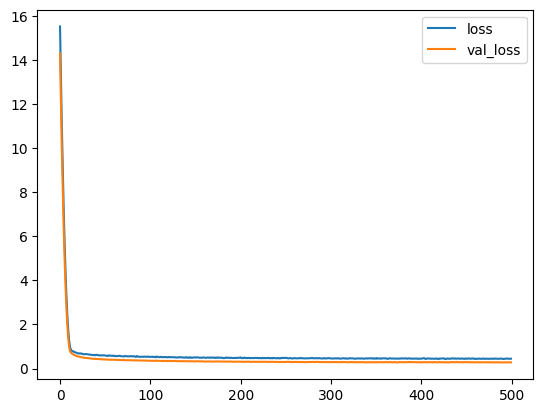

In [15]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

# the model seems to learn fairly well according to loss, not overfitting
# slight room for improvement

<Axes: >

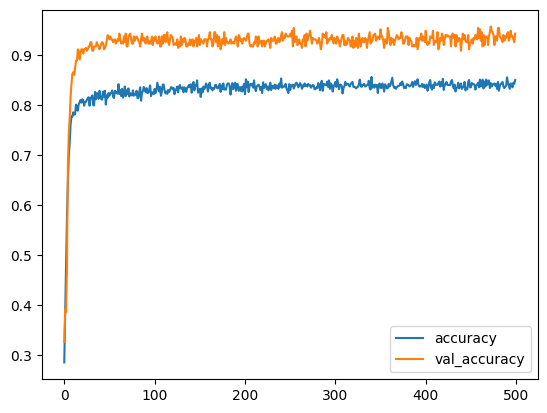

In [16]:
# the validation accuracy is quite high (which is the result from the test dataset)
# training accuracy is a bit low, but val_accuracy is usually more important to maximize
# training accuracy being low implies there's room for improvement still in the model
loss_df[['accuracy', 'val_accuracy']].plot()

In [17]:
# best_model_classification_opt1.keras
from keras.models import load_model
model = load_model('best_model_classification1_kt.keras')

In [18]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.2645626962184906, 0.9571428298950195]

Train data evaluation:
[0.2692701816558838, 0.9453846216201782]


In [19]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<Axes: >

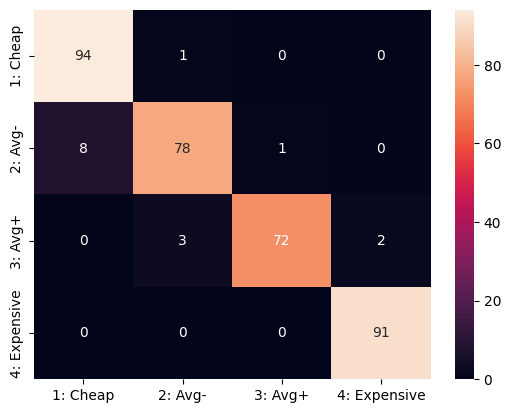

In [20]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

In [21]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    1: Cheap       0.92      0.99      0.95        95
     2: Avg-       0.95      0.90      0.92        87
     3: Avg+       0.99      0.94      0.96        77
4: Expensive       0.98      1.00      0.99        91

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350


Model overall accuracy: 95.71%


In [ ]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary classification, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


0.9988023333333333

### Test the model in practice with new data

In [ ]:
X.columns

Index(['battery_power', 'fc', 'int_memory', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'],
      dtype='object')

In [ ]:
df.head(3)

,battery_power,fc,int_memory,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,1,7,188,2,2,20,756,2549,9,7,19,2: Avg-
1,1021,0,53,136,3,6,905,1988,2631,17,3,7,3: Avg+
2,563,2,41,145,5,6,1263,1716,2603,11,2,9,3: Avg+


In [ ]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'battery_power': 1021, 
    'fc': 0, 
    'int_memory': 53, 
    'mobile_wt': 136, 
    'n_cores': 3, 
    'pc': 6,
    'px_height': 905, 
    'px_width': 1988, 
    'ram': 3031, 
    'sc_h': 17, 
    'sc_w': 3, 
    'talk_time': 7 
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

# switch to decimal representation 
np.set_printoptions(precision=9, suppress=True)

# 0 cheapest, 3 most expensive
print(f"Predicted price range: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted price range: 4: Expensive

Probabilities by class:
['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']
[0.          0.000056774 0.11943996  0.88050324 ]
